# Bellman-Ford

## Implementation of basic structures and algorithm

In [9]:
mutable struct WEdge
    u::Int
    v::Int
    w::Float64
end

mutable struct WGraph
    adj::Dict{Int, Vector{WEdge}}
end

function addedge!(g::WGraph, u::Int, v::Int, w::Float64)
    if !haskey(g.adj, u)
        g.adj[u] = Vector{WEdge}()
    end
    if !haskey(g.adj, v)
        g.adj[v] = Vector{WEdge}()
    end

    push!(g.adj[u], WEdge(u, v, w))
end

# Init single source function
function initsinglesource(graph::WGraph, s::Int)
    dist = Dict{Int, Float64}()
    pred = Dict{Int, Union{Int, Nothing}}()

    for v_node in keys(graph.adj)
        dist[v_node] = Inf
        pred[v_node] = nothing
    end

    dist[s] = 0.0
    if !haskey(pred, s)
        pred[s] = nothing
    end

    return dist, pred
end

# Relaxing function
function relax!(dist::Dict{Int, Float64}, pred::Dict{Int, Union{Int, Nothing}}, u::Int, v::Int, w::Float64)
    if haskey(dist, u) && dist[u] != Inf
        if dist[v] > dist[u] + w
            dist[v] = dist[u] + w
            pred[v] = u
        end
    end
end

# Bellman-Ford algorithm
function bellmanford(graph::WGraph, s::Int)
    dist, pred = initsinglesource(graph, s)
    num_nodes_in_consideration = length(keys(dist))


    for _ in 1:max(0, num_nodes_in_consideration - 1)
        for u_node in keys(graph.adj)
            for edge in graph.adj[u_node]
                relax!(dist, pred, edge.u, edge.v, edge.w)
            end
        end
    end

    for u_node in keys(graph.adj)
        for edge in graph.adj[u_node]
            if haskey(dist, edge.u) && dist[edge.u] != Inf
                if dist[edge.v] > dist[edge.u] + edge.w
                    return false, dist, pred
                end
            end
        end
    end

    return true, dist, pred
end

bellmanford (generic function with 1 method)

## Experiment functions

In [10]:
using Random
using BenchmarkTools
using Statistics
using Dates

Random.seed!(12345)  # For reproducibility

function generate_weighted_graph(n::Int, edge_prob::Float64, neg_weight_prob::Float64 = 0.3)
    g = WGraph(Dict{Int, Vector{WEdge}}())

    for i in 1:n
        if !haskey(g.adj, i)
            g.adj[i] = Vector{WEdge}()
        end
    end

    for u in 1:n
        for v in 1:n
            if u != v && rand() < edge_prob
                weight = if rand() < neg_weight_prob
                    rand(-5.0:1.0:-1.0)  # Negative weight
                else
                    rand(0.0:1.0:10.0)  # Positive weight or 0
                end
                addedge!(g, u, v, weight)
            end
        end
    end
    return g
end

function estimate_instances_bf(graph::WGraph, s::Int, target_time::Float64)
    test_instances = 5
    instance_times = Float64[]
    avg_time = mean(instance_times)

    if isempty(graph.adj) && !haskey(graph.adj, s)
        return max(1, Int(round(target_time / 1e-9)))
    end

    for _ in 1:test_instances
        push!(instance_times, @elapsed bellmanford(graph, s))
    end
        
    avg_time = mean(instance_times)
    if avg_time == 0.0
        avg_time = 1e-9  # Avoid division by zero
    end
    return max(1, Int(round(target_time / avg_time)))
end

function measure_bf_time(graph::WGraph, s::Int, target_time::Float64)
    instances = estimate_instances_bf(graph, s, target_time)
    instance_times = Vector{Float64}()
    negative_cycle_detections = 0

    if instances > 0 && !isempty(graph.adj) && haskey(graph.adj, s)
        _, _, _ = bellmanford(graph, s)
    end

    for _ in 1:instances
        has_no_neg_cycle = true
        run_time = @elapsed begin
            has_no_neg_cycle, _, _ = bellmanford(graph, s)
        end
        push!(instance_times, run_time)

        if !has_no_neg_cycle
            negative_cycle_detections += 1
        end
    end

    if isempty(instance_times)
        return 0.0, 0.0, 0.0, instances, Float64[], negative_cycle_detections
    end

    avg_time = mean(instance_times)
    median_time = median(instance_times)
    total_time = sum(instance_times)

    return avg_time, median_time, total_time, instances, instance_times, negative_cycle_detections
end

function run_bellmanford_experiment(
    sizes::Vector{Int}=[50, 100, 200, 400],
    edge_prob::Float64 = 0.2,
    neg_weight_prob::Float64 = 0.1, 
    target_time_per_size::Float64 = 20.0
)
    all_times = Vector{Vector{Float64}}()
    all_neg_cycle_info = Vector{Tuple{Int, Int}}()

    println("Starting Bellman-Ford Experiment...")
    println("Parameters: edge_prob=$edge_prob, neg_weight_prob=$neg_weight_prob, target_time_per_size=$target_time_per_size")

    for n_nodes in sizes
        println("--------------------------------------------------")
        println("Measuring Bellman-Ford for graph size: $n_nodes")
        g = generate_weighted_graph(n_nodes, edge_prob, neg_weight_prob)
        num_actual_edges = sum(length(v) for v in values(g.adj))
        println("Generated graph with N=$n_nodes, M=$num_actual_edges edges.")

        source_node = (n_nodes > 0) ? 1 : -1
        if source_node == -1 && n_nodes > 0
            println("Warning: No valid source node for N=$n_nodes")
            push!(all_times, Float64[])
            push!(all_neg_cycle_info, (0,0))
            continue
        end

        if n_nodes == 0
             push!(all_times, Float64[])
             push!(all_neg_cycle_info, (0,0))
             println("Size: $n_nodes | Instances: 0 | Avg Time: N/A | Median Time: N/A | Total Time: N/A | Neg Cycles Found: N/A")
             continue
        end

        avg_time, median_time, total_time, instances, instance_times_for_size, neg_cycles =
            measure_bf_time(g, source_node, target_time_per_size)

        push!(all_times, instance_times_for_size)
        push!(all_neg_cycle_info, (neg_cycles, instances))

        println("Size: $n_nodes | Instances: $instances | Avg Time: $avg_time s | Median Time: $median_time s | Total Time: $total_time s | Neg Cycles Found: $neg_cycles/$instances")
    end

    println("--------------------------------------------------")
    println("\nNegative Cycle Summary (Detections/Total Runs for that graph):")
    for (i, n_nodes) in enumerate(sizes)
        if n_nodes == 0 continue end
        detections, total_runs = all_neg_cycle_info[i]
        println("Size $n_nodes: $detections / $total_runs negative cycle detections.")
    end
    println("Experiment Finished.")
    return all_times, sizes
end

run_bellmanford_experiment (generic function with 5 methods)

## Run experiment and generate violin plot

Starting Bellman-Ford Experiment...
Parameters: edge_prob=0.2, neg_weight_prob=0.05, target_time_per_size=420.0
--------------------------------------------------
Measuring Bellman-Ford for graph size: 50
Generated graph with N=50, M=503 edges.
Size: 50 | Instances: 567767 | Avg Time: 0.000497477906606055 s | Median Time: 0.0004867 s | Total Time: 282.4515386 s | Neg Cycles Found: 567767/567767
--------------------------------------------------
Measuring Bellman-Ford for graph size: 100
Generated graph with N=100, M=2004 edges.
Size: 100 | Instances: 105390 | Avg Time: 0.004350099111870197 s | Median Time: 0.0041128 s | Total Time: 458.4569454 s | Neg Cycles Found: 105390/105390
--------------------------------------------------
Measuring Bellman-Ford for graph size: 200
Generated graph with N=200, M=7994 edges.
Size: 200 | Instances: 12195 | Avg Time: 0.03534052571545715 s | Median Time: 0.034876 s | Total Time: 430.97771109999996 s | Neg Cycles Found: 12195/12195
--------------------

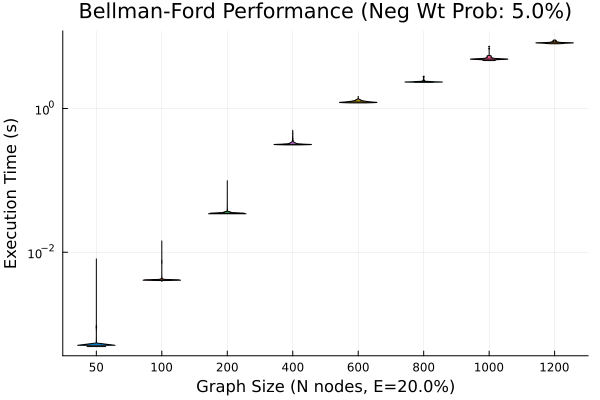

In [11]:
using StatsPlots

experiment_sizes = [50, 100, 200, 400, 600, 800, 1000, 1200]
experiment_edge_prob = 0.2
experiment_neg_weight_prob = 0.05
experiment_target_time = 420.0 

bf_times, bf_plot_sizes = run_bellmanford_experiment(
    experiment_sizes,
    experiment_edge_prob,
    experiment_neg_weight_prob,
    experiment_target_time
)

sizes_series_bf = [string(s) for s in bf_plot_sizes]
valid_indices = [i for (i, t_list) in enumerate(bf_times) if !isempty(t_list)]
filtered_bf_times = bf_times[valid_indices]
filtered_sizes_series_bf = sizes_series_bf[valid_indices]

if !isempty(filtered_bf_times)
    display(violin(
        permutedims(filtered_sizes_series_bf),
        filtered_bf_times,
        xlabel = "Graph Size (N nodes, E=$(experiment_edge_prob*100)%)",
        ylabel = "Execution Time (s)",
        title = "Bellman-Ford Performance (Neg Wt Prob: $(experiment_neg_weight_prob*100)%)",
        show_median = true,
        legend = false,
        yscale = :log10,
        linecolor=:auto,
        fillcolor=:auto
    ))

    plot_filename = "plots/bellman_ford_violin_$(Dates.format(Dates.now(), "yyyymmdd_HHMMSS")).png"
    try
        mkpath("plots")
        savefig(plot_filename)
        println("Plot saved to $plot_filename")
    catch e
        println("Error saving plot: $e")
    end
else
    println("No data to plot. Experiment might have had issues or all sizes resulted in no instances.")
end

## No negative weights

Starting Bellman-Ford Experiment...
Parameters: edge_prob=0.2, neg_weight_prob=0.0, target_time_per_size=420.0
--------------------------------------------------
Measuring Bellman-Ford for graph size: 50
Generated graph with N=50, M=472 edges.
Size: 50 | Instances: 647768 | Avg Time: 0.00042987323424435904 s | Median Time: 0.0004188 s | Total Time: 278.4581252 s | Neg Cycles Found: 0/647768
--------------------------------------------------
Measuring Bellman-Ford for graph size: 100
Generated graph with N=100, M=1972 edges.
Size: 100 | Instances: 114737 | Avg Time: 0.0036965274262007897 s | Median Time: 0.0036296 s | Total Time: 424.1284673 s | Neg Cycles Found: 0/114737
--------------------------------------------------
Measuring Bellman-Ford for graph size: 200
Generated graph with N=200, M=7928 edges.
Size: 200 | Instances: 14590 | Avg Time: 0.028576765496915697 s | Median Time: 0.028407050000000003 s | Total Time: 416.9350086 s | Neg Cycles Found: 0/14590
--------------------------

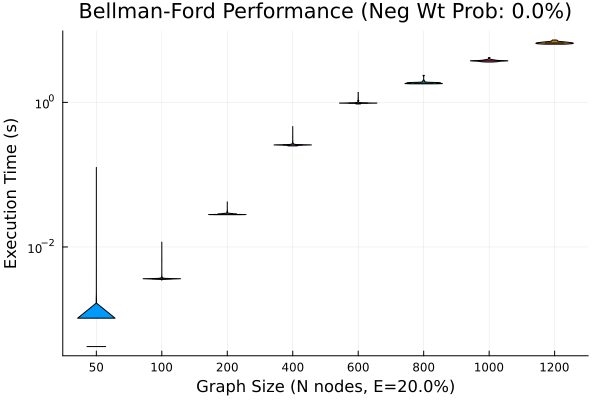

In [12]:
experiment_sizes = [50, 100, 200, 400, 600, 800, 1000, 1200]
experiment_edge_prob = 0.2
experiment_neg_weight_prob = 0.0
experiment_target_time = 420.0 

bf_times, bf_plot_sizes = run_bellmanford_experiment(
    experiment_sizes,
    experiment_edge_prob,
    experiment_neg_weight_prob,
    experiment_target_time
)

sizes_series_bf = [string(s) for s in bf_plot_sizes]
valid_indices = [i for (i, t_list) in enumerate(bf_times) if !isempty(t_list)]
filtered_bf_times = bf_times[valid_indices]
filtered_sizes_series_bf = sizes_series_bf[valid_indices]

if !isempty(filtered_bf_times)
    display(violin(
        permutedims(filtered_sizes_series_bf),
        filtered_bf_times,
        xlabel = "Graph Size (N nodes, E=$(experiment_edge_prob*100)%)",
        ylabel = "Execution Time (s)",
        title = "Bellman-Ford Performance (Neg Wt Prob: $(experiment_neg_weight_prob*100)%)",
        show_median = true,
        legend = false,
        yscale = :log10,
        linecolor=:auto,
        fillcolor=:auto
    ))

    plot_filename = "plots/bellman_ford_violin_$(Dates.format(Dates.now(), "yyyymmdd_HHMMSS")).png"
    try
        mkpath("plots")
        savefig(plot_filename)
        println("Plot saved to $plot_filename")
    catch e
        println("Error saving plot: $e")
    end
else
    println("No data to plot. Experiment might have had issues or all sizes resulted in no instances.")
end